In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
from datasets import load_dataset
import numpy as np
import evaluate
import ast
import os
from pathlib import Path
import pandas as pd


/home/hevagog/Studies/advanced-data-mining/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First used `t5-small` model from Hugging Face Transformers for sequence-to-sequence tasks. It's a 60M s2s model, trained primarily on summarization and translation tasks.

Now we'll use `flan-t5-base`, a 250M parameter model specifically trained to follow instructions better.

In [2]:
dataset_path = os.path.join(Path.cwd().parent, 'data', 'data_for_s2s.csv')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_CHECKPOINT = "t5-small"
MAX_INPUT_LENGTH = 512
MAX_TARGET_LENGTH = 64
BATCH_SIZE = 16

In [3]:
dataset = load_dataset("csv", data_files=dataset_path, split="train", streaming=True)

In [4]:
test_size = 5000
dataset_shuffled = dataset.shuffle(buffer_size=1000, seed=42)
train_dataset = dataset_shuffled.skip(test_size)
eval_dataset = dataset_shuffled.take(test_size)

In [5]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

In [6]:
def clean_text(text):
    return " ".join(str(text).split())

In [7]:
def preprocess_function(examples):
    inputs = []
    targets = []
    
    for i in range(len(examples['title'])):
        # 1. Input: Combine Title and Question Text
        title = str(examples['title'][i]).strip()
        body = str(examples['question_text'][i]).strip()
        
        # T5 Input Format
        input_text = f"predict tags: {title} \n {body}"
        inputs.append(input_text)
        
        # 2. Target: Parse the list string "['tag1', 'tag2']"
        raw_tags = examples['tags'][i]
        try:
            # Safely convert string "['a', 'b']" to list ['a', 'b']
            tag_list = ast.literal_eval(raw_tags)
            if not isinstance(tag_list, list):
                tag_list = []
        except:
            tag_list = []
            
        # Sort alphabetically to help the model learn order
        tag_list = sorted(list(set(tag_list)))
        target_text = ", ".join(tag_list) # "entity-framework, .net"
        targets.append(target_text)

    # 3. Tokenization
    model_inputs = tokenizer(inputs, max_length=MAX_INPUT_LENGTH, truncation=True)
    labels = tokenizer(text_target=targets, max_length=MAX_TARGET_LENGTH, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [8]:
cols_to_remove = ["question_id", "title", "question_text", "tags"]
train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=cols_to_remove)
eval_dataset = eval_dataset.map(preprocess_function, batched=True, remove_columns=cols_to_remove)

In [ ]:
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    matched = 0
    total_pred = 0
    total_true = 0
    
    for p, l in zip(decoded_preds, decoded_labels):
        p_tags = set([t.strip() for t in p.split(',') if t.strip()])
        l_tags = set([t.strip() for t in l.split(',') if t.strip()])
        
        matched += len(p_tags.intersection(l_tags))
        total_pred += len(p_tags)
        total_true += len(l_tags)
        
    precision = matched / (total_pred + 1e-9)
    recall = matched / (total_true + 1e-9)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
    
    return {"f1_micro": f1}

In [10]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_CHECKPOINT)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./t5_tag_predictor",
    eval_strategy="steps",
    eval_steps=1000,           
    logging_steps=100,
    save_steps=1000,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=3e-4,       
    weight_decay=0.01,
    gradient_accumulation_steps=4,
    # gradient_checkpointing=True,
    save_total_limit=3,
    max_steps=20_000,
    predict_with_generate=True, 
    generation_num_beams=3,
    generation_max_length=64,
    label_smoothing_factor=0.1, 
    bf16=True,                
)

In [12]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,    
)

/tmp/ipykernel_3200/4199021448.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [13]:
trainer.train()

Step,Training Loss,Validation Loss,F1 Micro
1000,2.228300,2.134054,0.505285
2000,2.085400,2.013017,0.568980
3000,2.029700,1.958142,0.599241
4000,1.958500,1.933776,0.604892
5000,1.938900,1.907624,0.624918
6000,1.928500,1.888823,0.635656
7000,1.881100,1.884363,0.636216
8000,1.875000,1.871695,0.644270
9000,1.878200,1.862406,0.648290
10000,1.830800,1.865387,0.650012


TrainOutput(global_step=20000, training_loss=1.903396541595459, metrics={'train_runtime': 18581.9125, 'train_samples_per_second': 68.884, 'train_steps_per_second': 1.076, 'total_flos': 1.7324070333421978e+17, 'train_loss': 1.903396541595459, 'epoch': 13.0354})

The first model `t5-small` performed decently, after 10000 steps achieved F1 Micro score of 0.538935. 

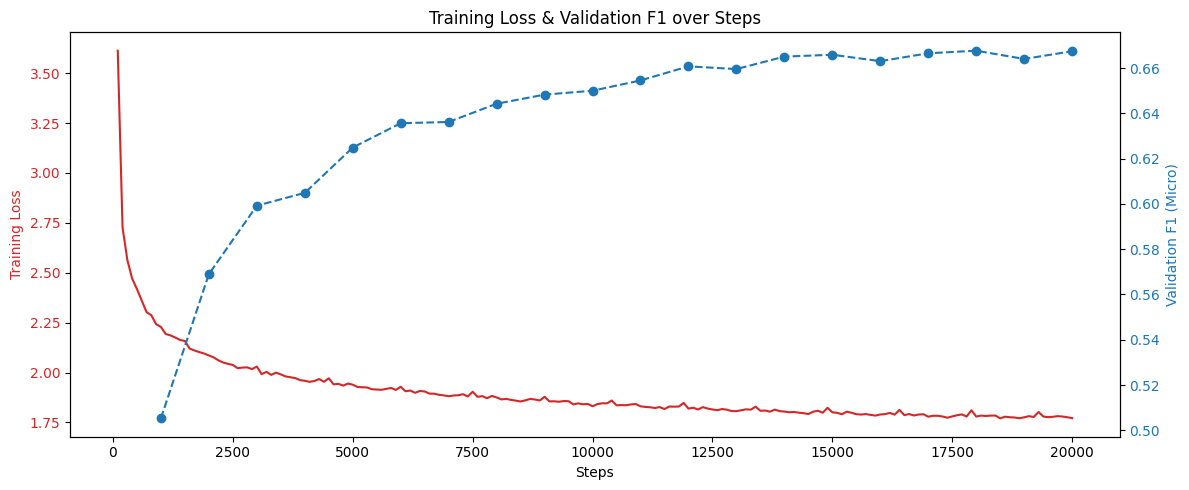

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(trainer):
    history = trainer.state.log_history
    
    train_loss = []
    eval_f1 = []
    steps_loss = []
    steps_f1 = []
    
    for entry in history:
        if 'loss' in entry:
            train_loss.append(entry['loss'])
            steps_loss.append(entry['step'])
        if 'eval_f1_micro' in entry:
            eval_f1.append(entry['eval_f1_micro'])
            steps_f1.append(entry['step'])
            
    # Create plots
    fig, ax1 = plt.subplots(figsize=(12, 5))

    # Plot Training Loss
    color = 'tab:red'
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Training Loss', color=color)
    ax1.plot(steps_loss, train_loss, color=color, label='Train Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Create a second y-axis for F1 Score
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Validation F1 (Micro)', color=color)
    ax2.plot(steps_f1, eval_f1, color=color, marker='o', linestyle='dashed', label='Val F1')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Training Loss & Validation F1 over Steps')
    fig.tight_layout()
    plt.show()

# Visualize
plot_metrics(trainer)

In [ ]:
def predict_custom_question(title, body):

    text = f"predict tags: {title} \n {body}"
    
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True).to(model.device)
    
    outputs = model.generate(
        inputs["input_ids"], 
        max_new_tokens=64, 
        num_beams=5
    )
    
    tags = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return tags


In [16]:
t = "How do I reverse a list?"
b = "I have a list [1, 2, 3] and I want [3, 2, 1]. slicing doesn't work for me. I'm thinking of using a pandas library "
print(predict_custom_question(t, b))

dataframe, python, sorting


In [ ]:
# trainer.save_model(os.path.join(Path.cwd().parent, 'data', 's2s_model'))
# tokenizer.save_pretrained(os.path.join(Path.cwd().parent, 'data', 's2s_model'))

('/home/hevagog/Studies/advanced-data-mining/data/s2s_model/tokenizer_config.json',
 '/home/hevagog/Studies/advanced-data-mining/data/s2s_model/special_tokens_map.json',
 '/home/hevagog/Studies/advanced-data-mining/data/s2s_model/tokenizer.json')

In [23]:
import pandas as pd

def show_sample_predictions(model, tokenizer, dataset, num_samples=5):
    model.eval()
    device = model.device
    
    samples = list(dataset.take(num_samples))
    
    for sample in samples:
        input_ids = torch.tensor(sample['input_ids']).unsqueeze(0).to(device)
        
        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids, 
                max_new_tokens=64,
                num_beams=5, # Beam search for better quality
                early_stopping=True
            )
        
        pred_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        labels = sample['labels']
        labels = [l if l != -100 else tokenizer.pad_token_id for l in labels]
        actual_text = tokenizer.decode(labels, skip_special_tokens=True)
        
        print(f"{pred_text:<40} | {actual_text:<40}")


In [24]:
show_sample_predictions(model, tokenizer, eval_dataset)

image, typescript                        | image, r, server, typescript, uikit     
reactjs, tailwind-css-4, typescript      | reactjs, tailwind-css-4                 
android, server                          | android, oauth, server                  
.net, stripe-payments                    | .net                                    
lambda, typescript                       | shell, typescript                       


In [20]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    
    # 1. Replace -100 in predictions and labels
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    
    # 2. Decode to text
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # 3. Parse strings into lists of tags
    # We need lists of strings for MultiLabelBinarizer
    pred_tags_list = []
    label_tags_list = []
    
    for p, l in zip(decoded_preds, decoded_labels):
        # Clean and split: "tag1, tag2" -> {'tag1', 'tag2'}
        p_tags = set([t.strip() for t in p.split(',') if t.strip()])
        l_tags = set([t.strip() for t in l.split(',') if t.strip()])
        
        pred_tags_list.append(list(p_tags))
        label_tags_list.append(list(l_tags))
        
    # 4. Convert to Binary Matrix using MultiLabelBinarizer
    # This automatically handles the mapping of thousands of unique strings to columns
    mlb = MultiLabelBinarizer()
    
    # Fit on BOTH predictions and labels to ensure we capture all unique tags
    # seen in this evaluation batch/epoch
    mlb.fit(pred_tags_list + label_tags_list)
    
    y_pred = mlb.transform(pred_tags_list)
    y_true = mlb.transform(label_tags_list)
    
    # 5. Compute Metrics
    # Macro: Calculate F1 for each tag, then average (treats rare tags equal to common tags)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    # Micro: Global count of TP/FP/FN (your original metric, biased towards common tags)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    
    # (Optional) Weighted: Macro average weighted by support (frequency)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    return {
        "f1_macro": f1_macro,
        "f1_micro": f1_micro,
        "f1_weighted": f1_weighted
    }

In [ ]:
import torch
from tqdm.auto import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, f1_score

def evaluate_f1_on_dataset(model, tokenizer, dataset, batch_size=8):
    model.eval()
    device = model.device
    
    pred_tags_list = []
    true_tags_list = []
    
    print(f"Starting evaluation on {device}...")
    
    batch_input_ids = []
    batch_labels = []
    
    def process_batch(b_input_ids, b_labels):
        # To be safe against OOM and padding issues without a DataCollator, 
        # we will process this small batch item-by-item or stacked if possible.
        # Ideally, stack them.
        try:
            input_tensor = torch.tensor(b_input_ids).to(device)
        except ValueError:
            # If lengths differ (no padding applied yet), fall back to loop
            # This is slow but guaranteed to work without a Collator
            for i in range(len(b_input_ids)):
                _process_single(b_input_ids[i], b_labels[i])
            return

        # 2. Generate
        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_tensor,
                max_new_tokens=64,
                num_beams=3, 
                early_stopping=True
            )
        
        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        
        # Replace -100 with pad_token_id before decoding
        clean_labels = [
            [l if l != -100 else tokenizer.pad_token_id for l in label] 
            for label in b_labels
        ]
        decoded_labels = tokenizer.batch_decode(clean_labels, skip_special_tokens=True)
        
        for p, l in zip(decoded_preds, decoded_labels):
            p_clean = set([t.strip() for t in p.split(',') if t.strip()])
            l_clean = set([t.strip() for t in l.split(',') if t.strip()])
            pred_tags_list.append(list(p_clean))
            true_tags_list.append(list(l_clean))

    def _process_single(inp, lbl):
        # Fallback for ragged batches
        inp_tensor = torch.tensor(inp).unsqueeze(0).to(device)
        with torch.no_grad():
            out = model.generate(inp_tensor, max_new_tokens=64, num_beams=3)
        pred = tokenizer.decode(out[0], skip_special_tokens=True)
        
        lbl_clean = [l if l != -100 else tokenizer.pad_token_id for l in lbl]
        actual = tokenizer.decode(lbl_clean, skip_special_tokens=True)
        
        pred_tags_list.append(list(set([t.strip() for t in pred.split(',') if t.strip()])))
        true_tags_list.append(list(set([t.strip() for t in actual.split(',') if t.strip()])))

    for sample in tqdm(dataset, desc="Evaluating"):
        batch_input_ids.append(sample['input_ids'])
        batch_labels.append(sample['labels'])
        
        if len(batch_input_ids) >= batch_size:
            process_batch(batch_input_ids, batch_labels)
            batch_input_ids = []
            batch_labels = []
            
    if batch_input_ids:
        process_batch(batch_input_ids, batch_labels)

    print("Calculating Metrics...")
    
    mlb = MultiLabelBinarizer()
    mlb.fit(pred_tags_list + true_tags_list)
    
    y_pred = mlb.transform(pred_tags_list)
    y_true = mlb.transform(true_tags_list)
    
    micro_f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    print(f"Evaluation Results:")
    print(f"Micro F1: {micro_f1:.4f}")
    print(f"Macro F1: {macro_f1:.4f}")
    
    return {"micro": micro_f1, "macro": macro_f1}

In [22]:
metrics = evaluate_f1_on_dataset(model, tokenizer, eval_dataset, batch_size=8)

Starting evaluation on cuda:0...


Evaluating: 5000it [05:02, 16.55it/s]

Calculating Metrics...
Evaluation Results:
Micro F1: 0.6676
Macro F1: 0.6250
